In [183]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample, seed
from astropy.io import ascii, fits
from glob import glob
from usefulFuncs import ifind_tpfs
from LCFeatureExtraction import error_estimate, amplitude_estimate
from lightkurve import MPLSTYLE, DesignMatrix
from lightkurve import open as open_lc

# Assessing Flattening of Light Curves using Savitzky-Golay filter

I managed to create a good background subtraction pipeline that saves the light curves to FITS files into the `LightCurvesFITS` folder. However, further processing can, and must be done to the light curve in order to get rid of long-term trends due to ambigous causes. `lightkurve` give us a `LightCurve` method called `flatten` that will apply a Savitzky-Golay filter, from `scipy`. However, this filter if used without care will remove the very same trends that we are looking for. It is not a great filter for our project, but it will do for now. Other detrending procedures should eventually be put in place.

The Savitzky-Golay filter function will convolve a polynomial of $n$th order with a window size of $N_{win}$, across our light curve to smooth out any long term trends. The parameter to be assessed in this notebook will be the window size. I think the polynomial order will be fine when kept at second order given that we are expecting long term trends of approximately 1th order; making $n$th = 2 will leave space for any other anomalies. The window size is anothe story. If it is too small it will remove the slower oscillators in our signal; such as slow star rotators of ~10-15 days periods. If it is too big, it will not remove smaller scale trends, and might in fact add artifacts to our data.

### Assessment Procedure

In this notebook I will be assessing this method on a total of 14 light curves from the IC2391 cluster. 

#### Target Selection
I made three groups; **low**, **high**, and **mixed** frequency oscillations; where mixed means there is more than one dominant signal in the light curve. For each group I handpicked a "large" sample by skimming through the light curves collection (from this cluster), they all are in the folder `LightCurvesPlots`. Then I randomly picked a smaller sample of five targets for the low/high frequency groups. The mixed frequency group is so small that I simply used all four of them.

#### Aperture Selection
I have three different background subtracted light curves for each target. The difference being being the aperture selection; threshold, percentile, and handpicked. This is the _manual_ part of the notebook. For each target, I will be looking back at all three light curves, and deciding which one to use for assessing the flattening function. My decisions were based on the following: maximizing the range of cases, and visual confirmation of oscillation.

#### Window range trials
I will be performing the Savitzky-Golay filter on each light curve on a window range that can dynamically changed. During my own trials I made a range of window sizes from 101 to 581 in steps of 20; a total of 25 window sizes. 

#### Metric Calculation
While viual inspection is crucial, I will be calcualting an approximation to SNR that assummes a sinusoidal signal in the data; _amplitude / noise_. This value should provide quantitive support when deciding optimal window size. 

In [216]:
# Parameters
outlier_sigma = 3.0
window_start = 101
window_end = 600
window_step = 20
N_targets = 5
best_N_windows = 3
seed(123)

# Get filepaths to LightCurve FITS
src_lcfs = 'LightCurvesFITS/*.fits'
fits_paths = glob(src_lcfs)

# Get Chelsea's quality mask
with fits.open('DataInput/ClusterQuality/Sector8_Sample.fits.gz') as quality_sample:
    # For Chelsea's quality flags:
    #   0 means good, 1 means bad
    quality_flags = quality_sample[1].data['quality']
    good_mask = ~quality_flags.astype(bool)

colors = ['k' if flag else 'red' for flag in good_mask]
    
# Pool of hand picked targets with at least one light curve whose frequeancy appers to be high/low or mixed
high_IDs = ['92580385', '92581404', '93265597', '93022865', '93551193', '93630147', '93831298', '93912230', '144996772', '144997798']
mix_IDs = ['93550865', '93270923', '94185042', '144759493']
low_IDs = ['92475268', '92583560', '93013696', '93014257', '93016484', '93016484', '93269120', '93549309', '94107183', '14475228']

# Get smaller sample for low/high freq targets
high_sample = sample(high_IDs, N_targets)
low_sample = sample(low_IDs, N_targets)

# Array of flatten windows to sweep over
flatten_windows = np.arange(window_start, window_end, window_step, dtype=int)
flatten_windows

array([101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341,
       361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581])

## Assess high frequency sample

MANUALLY go over each target's light curve and pick the best aperture to represent that target

In [217]:
high_sample

['92580385', '93551193', '92581404', '93831298', '93022865']

Corresponding aperture types:

In [218]:
high_apt_types = 'OR', 'PC', 'OR', 'OR', 'PC'

Iterate over all target/aperture - window pairs.

In [219]:
# Prepare paths for iteration, and initialize SNR-values array
high_sample_paths = [f'LightCurvesFITS/{ticid}{ap}-targ.fits' for ap, ticid in zip(high_apt_types, high_sample)]
high_snr = np.zeros((N_targets, flatten_windows.size))

for i, high_path in enumerate(high_sample_paths):
    for j, window in enumerate(flatten_windows):
        clipped_lc, clipped_mask = open_lc(high_path).get_lightcurve('FLUX').remove_outliers(sigma=outlier_sigma, return_mask=True)
        flatten_lc = clipped_lc.flatten(window, return_trend=False, polyorder=2)

        # Estimate Features
        sigma = error_estimate(flatten_lc, quality=good_mask[~clipped_mask])
        high_snr[i, j] = amplitude_estimate(flatten_lc, quality=good_mask[~clipped_mask]) / (sigma / 1e6)

In [265]:
# Find the high SNR values of each target-aperture pair (SNR values above 75th percentile)
high_thresh_snr = np.percentile(high_snr, 75, axis=-1)
high_above_snr = high_snr > high_thresh_snr[:, None]

# Find the indeces for the windows that produced the highest SNR values
high_count_snr = high_above_snr.sum(axis=0)
high_unique_counts, high_unique_counts_indx = np.unique(high_count_snr, return_index=True)
top_windows_indx = high_unique_counts_indx[::-1][:best_N_windows]

/Users/joseperez/miniconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:667: LightkurveWarning: The light curve has a negative median flux (-6.44e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
/Users/joseperez/miniconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:667: LightkurveWarning: The light curve has a negative median flux (-4.65e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)


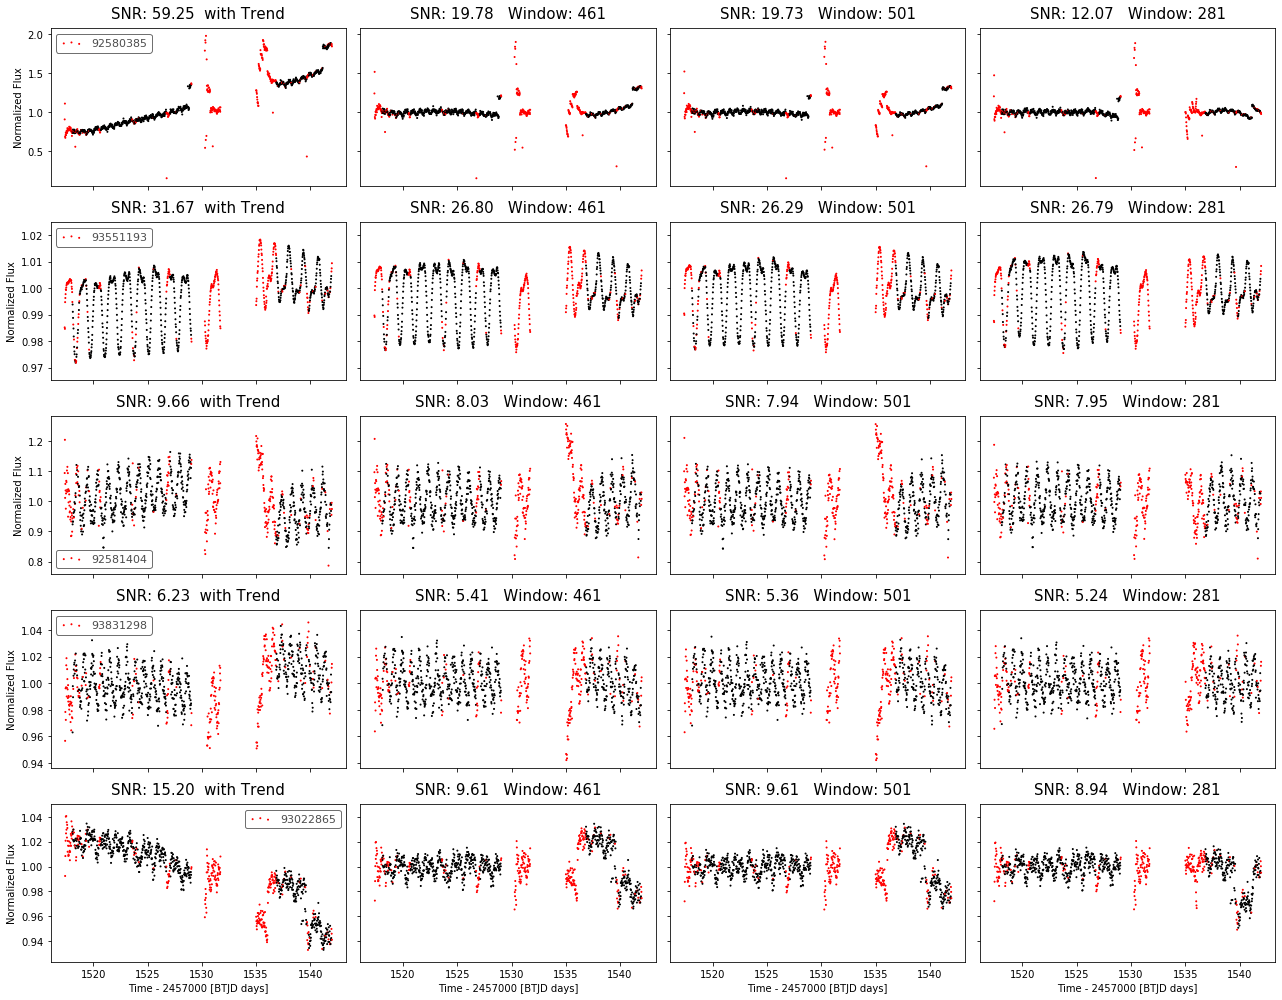

In [283]:
fig, axes = plt.subplots(N_targets, best_N_windows+1, figsize=(18, 14), sharey='row', sharex='all', )
for i, high_path in enumerate(high_sample_paths):
    # Each row will correspond to ONE target-aperture pair
    lc = open_lc(high_path).get_lightcurve('FLUX')
    clipped_lc, clipped_mask = lc.remove_outliers(sigma=outlier_sigma, return_mask=True)
    
    # Plot the light curve without flattening on the first column
    clipped_lc.scatter(ax=axes[i, 0], normalize=True, c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False)
    clipped_sigma = error_estimate(clipped_lc, quality=good_mask[~clipped_mask])
    clipped_snr = amplitude_estimate(clipped_lc, quality=good_mask[~clipped_mask]) / (clipped_sigma / 1e6)
    with plt.style.context(MPLSTYLE):
        axes[i, 0].set_title(f'SNR: {clipped_snr:.2f}  with Trend', fontsize=15)
    
    if not axes[i, 0].is_last_row():
        axes[i, 0].set_xlabel('')
        
    for j, window_indx in enumerate(top_windows_indx, start=1):
        window = flatten_windows[window_indx]
        flatten_lc, trend_lc = clipped_lc.flatten(window, return_trend=True, polyorder=2)
        
        flatten_lc.scatter(ax=axes[i, j], normalize=True, c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False, label='')
        
        if not axes[i, j].is_first_col():
            axes[i, j].set_ylabel('')
        if not axes[i, j].is_last_row():
            axes[i, j].set_xlabel('')
        # trend_lc.scatter(normalize=True)
        with plt.style.context(MPLSTYLE):
            axes[i, j].set_title(f'SNR: {high_snr[i, window_indx]:.2f}   Window: {window}', fontsize=15)
plt.tight_layout()

## Assess low frequency sample

MANUALLY go over each target's light curve and pick the best aperture to represent that target

In [270]:
low_sample

['93016484', '92583560', '92475268', '93014257', '14475228']

In [274]:
# for some reason there is a missing character in the last TIC ID name
low_sample[-1] = '144752281'

Corresponding aperture types:

In [272]:
low_apt_types = 'PC', 'TH', 'OR', 'OR', 'PC'

Iterate over all target/aperture - window pairs.

In [275]:
# Prepare paths for iteration, and initialize SNR-values array
low_sample_paths = [f'LightCurvesFITS/{ticid}{ap}-targ.fits' for ap, ticid in zip(low_apt_types, low_sample)]
low_snr = np.zeros((N_targets, flatten_windows.size))

for i, low_path in enumerate(low_sample_paths):
    for j, window in enumerate(flatten_windows):
        clipped_lc, clipped_mask = open_lc(low_path).get_lightcurve('FLUX').remove_outliers(sigma=outlier_sigma, return_mask=True)
        flatten_lc = clipped_lc.flatten(window, return_trend=False, polyorder=2)

        # Estimate Features
        sigma = error_estimate(flatten_lc, quality=good_mask[~clipped_mask])
        low_snr[i, j] = amplitude_estimate(flatten_lc, quality=good_mask[~clipped_mask]) / (sigma / 1e6)

In [276]:
# Find the high SNR values of each target-aperture pair (SNR values above 75th percentile)
low_thresh_snr = np.percentile(low_snr, 75, axis=-1)
low_above_snr = low_snr > low_thresh_snr[:, None]

# Find the indeces for the windows that produced the highest SNR values
low_count_snr = low_above_snr.sum(axis=0)
low_unique_counts, low_unique_counts_indx = np.unique(low_count_snr, return_index=True)
top_windows_indx = low_unique_counts_indx[::-1][:best_N_windows]

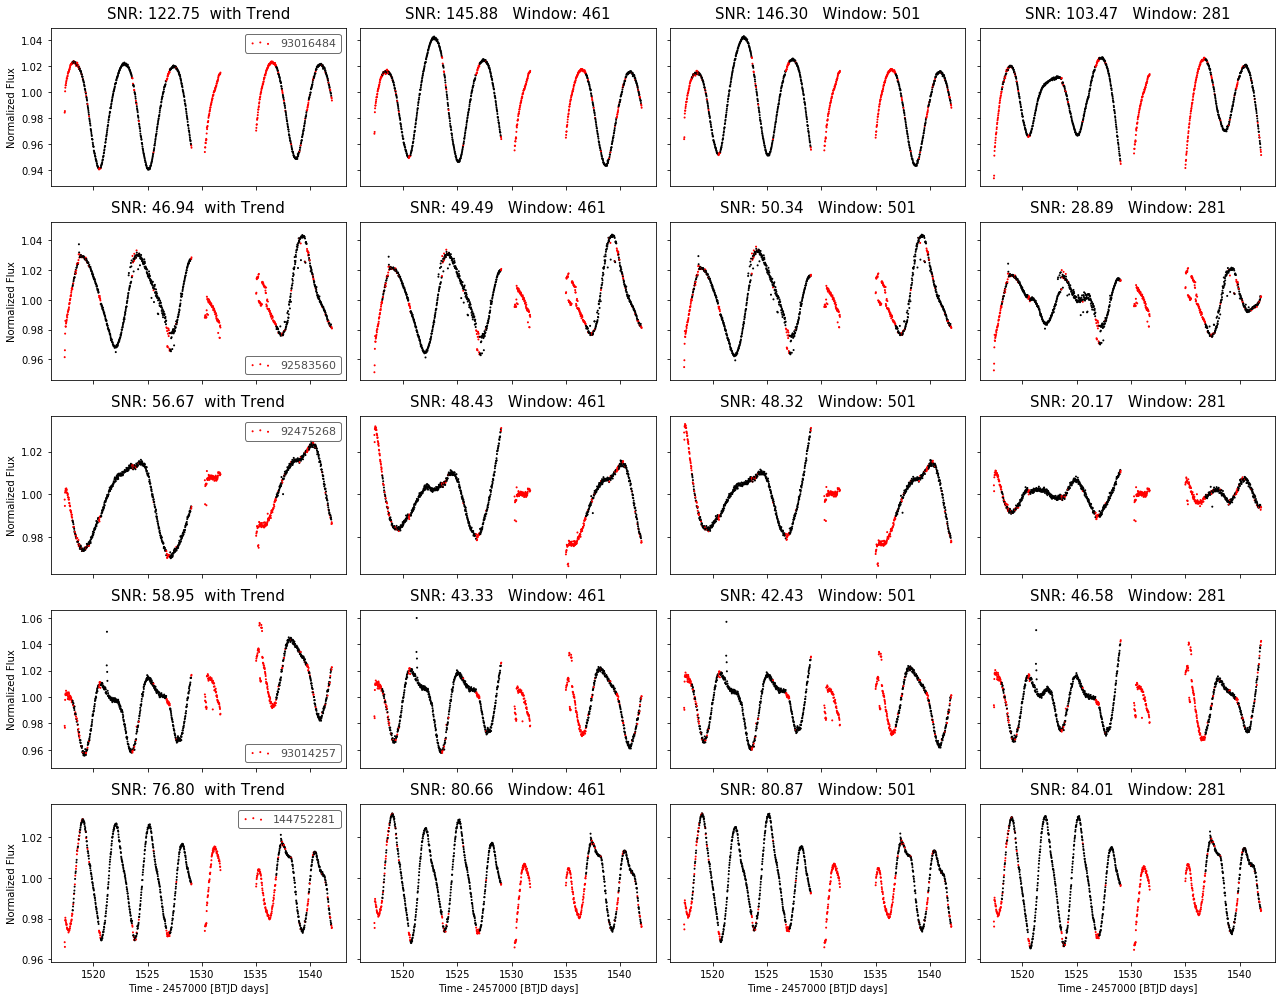

In [284]:
fig, axes = plt.subplots(N_targets, best_N_windows+1, figsize=(18, 14), sharey='row', sharex='all', )
for i, low_path in enumerate(low_sample_paths):
    # Each row will correspond to ONE target-aperture pair
    lc = open_lc(low_path).get_lightcurve('FLUX')
    clipped_lc, clipped_mask = lc.remove_outliers(sigma=outlier_sigma, return_mask=True)
    
    # Plot the light curve without flattening on the first column
    clipped_lc.scatter(ax=axes[i, 0], normalize=True, c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False)
    clipped_sigma = error_estimate(clipped_lc, quality=good_mask[~clipped_mask])
    clipped_snr = amplitude_estimate(clipped_lc, quality=good_mask[~clipped_mask]) / (clipped_sigma / 1e6)
    with plt.style.context(MPLSTYLE):
        axes[i, 0].set_title(f'SNR: {clipped_snr:.2f}  with Trend', fontsize=15)
    
    if not axes[i, 0].is_last_row():
        axes[i, 0].set_xlabel('')
        
    for j, window_indx in enumerate(top_windows_indx, start=1):
        window = flatten_windows[window_indx]
        flatten_lc, trend_lc = clipped_lc.flatten(window, return_trend=True, polyorder=2)
        
        flatten_lc.scatter(ax=axes[i, j], normalize=True, c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False, label='')
        
        if not axes[i, j].is_first_col():
            axes[i, j].set_ylabel('')
        if not axes[i, j].is_last_row():
            axes[i, j].set_xlabel('')
        # trend_lc.scatter(normalize=True)
        with plt.style.context(MPLSTYLE):
            axes[i, j].set_title(f'SNR: {low_snr[i, window_indx]:.2f}   Window: {window}', fontsize=15)
plt.tight_layout()

## Assess mixed frequency sample

MANUALLY go over each target's light curve and pick the best aperture to represent that target

In [286]:
mix_IDs

['93550865', '93270923', '94185042', '144759493']

In [287]:
# Override number of targets
N_targets = 4

Corresponding aperture types:

In [290]:
mix_apt_types = 'OR', 'TH', 'OR', 'OR'

Iterate over all target/aperture - window pairs.

In [291]:
# Prepare paths for iteration, and initialize SNR-values array
mix_sample_paths = [f'LightCurvesFITS/{ticid}{ap}-targ.fits' for ap, ticid in zip(mix_apt_types, mix_IDs)]
mix_snr = np.zeros((N_targets, flatten_windows.size))

for i, mix_path in enumerate(mix_sample_paths):
    for j, window in enumerate(flatten_windows):
        clipped_lc, clipped_mask = open_lc(mix_path).get_lightcurve('FLUX').remove_outliers(sigma=outlier_sigma, return_mask=True)
        flatten_lc = clipped_lc.flatten(window, return_trend=False, polyorder=2)

        # Estimate Features
        sigma = error_estimate(flatten_lc, quality=good_mask[~clipped_mask])
        mix_snr[i, j] = amplitude_estimate(flatten_lc, quality=good_mask[~clipped_mask]) / (sigma / 1e6)

In [292]:
# Find the high SNR values of each target-aperture pair (SNR values above 75th percentile)
mix_thresh_snr = np.percentile(mix_snr, 75, axis=-1)
mix_above_snr = mix_snr > mix_thresh_snr[:, None]

# Find the indeces for the windows that produced the highest SNR values
mix_count_snr = mix_above_snr.sum(axis=0)
mix_unique_counts, mix_unique_counts_indx = np.unique(mix_count_snr, return_index=True)
top_windows_indx = mix_unique_counts_indx[::-1][:best_N_windows]

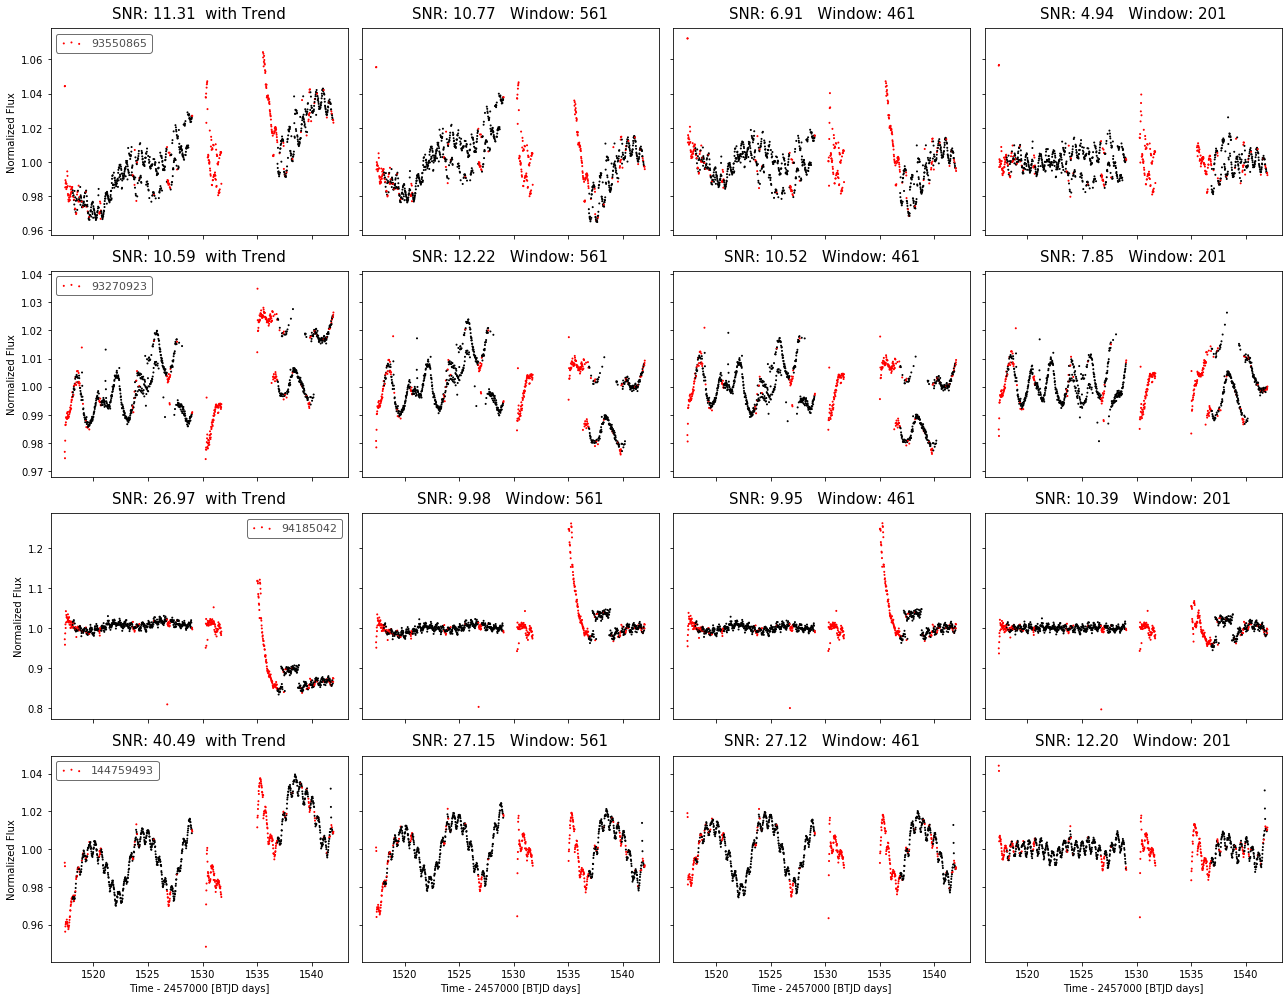

In [293]:
fig, axes = plt.subplots(N_targets, best_N_windows+1, figsize=(18, 14), sharey='row', sharex='all', )
for i, mix_path in enumerate(mix_sample_paths):
    # Each row will correspond to ONE target-aperture pair
    lc = open_lc(mix_path).get_lightcurve('FLUX')
    clipped_lc, clipped_mask = lc.remove_outliers(sigma=outlier_sigma, return_mask=True)
    
    # Plot the light curve without flattening on the first column
    clipped_lc.scatter(ax=axes[i, 0], normalize=True, c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False)
    clipped_sigma = error_estimate(clipped_lc, quality=good_mask[~clipped_mask])
    clipped_snr = amplitude_estimate(clipped_lc, quality=good_mask[~clipped_mask]) / (clipped_sigma / 1e6)
    with plt.style.context(MPLSTYLE):
        axes[i, 0].set_title(f'SNR: {clipped_snr:.2f}  with Trend', fontsize=15)
    
    if not axes[i, 0].is_last_row():
        axes[i, 0].set_xlabel('')
        
    for j, window_indx in enumerate(top_windows_indx, start=1):
        window = flatten_windows[window_indx]
        flatten_lc, trend_lc = clipped_lc.flatten(window, return_trend=True, polyorder=2)
        
        flatten_lc.scatter(ax=axes[i, j], normalize=True, c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False, label='')
        
        if not axes[i, j].is_first_col():
            axes[i, j].set_ylabel('')
        if not axes[i, j].is_last_row():
            axes[i, j].set_xlabel('')
        # trend_lc.scatter(normalize=True)
        with plt.style.context(MPLSTYLE):
            axes[i, j].set_title(f'SNR: {mix_snr[i, window_indx]:.2f}   Window: {window}', fontsize=15)
plt.tight_layout()